# Neural Machine Translation

Resource: https://tsdaemon.github.io/2018/07/08/nmt-with-pytorch-encoder-decoder.html

![](https://tsdaemon.github.io/assets/images/nmt/Seq2Seq-thought-vector.png)

## 1. Data

For this tutorial I used bilingual datasets from https://tatoeba.org/en/downloads. You can download language pairs data from http://www.manythings.org/anki/ or use the code below (from https://github.com/tsdaemon/neural-experiments/blob/master/nmt/scripts/get_dataset.py )

(Optional)

In [ ]:
import subprocess
import os

import pandas as pd

#ISO 639-3 code for a source language

source_lang = 'eng'
target_lang = 'hun'
data_dir = './'

# download if sentences are not here
sentences_path = os.path.join(data_dir, 'sentences.csv')
if not os.path.isfile(sentences_path):
    if not os.path.isfile(os.path.join(data_dir, 'sentences.tar.bz2')):
        subprocess.run(
            "wget https://downloads.tatoeba.org/exports/sentences.tar.bz2 -P " + data_dir,
            shell=True)

    subprocess.run(
        "tar xvjC {0} -f {0}/sentences.tar.bz2".format(data_dir), shell=True)

# download if links are not here
links_path = os.path.join(data_dir, 'links.csv')
if not os.path.isfile(links_path):
    if not os.path.isfile(os.path.join(data_dir, 'links.tar.bz2')):
        subprocess.run(
            "wget https://downloads.tatoeba.org/exports/links.tar.bz2 -P " + data_dir,
            shell=True)

    subprocess.run("tar xvjC {0} -f {0}/links.tar.bz2".format(data_dir), shell=True)

# read all data
sentences = pd.read_csv(sentences_path, names=['id', 'lang', 'text'], header=None, delimiter='\t')
links = pd.read_csv(links_path, names=['sent_id', 'tran_id'], header=None, delimiter='\t')

# extract source - target connected
source_sentences = sentences[sentences.lang == source_lang]
source_sentences = source_sentences.merge(links, left_on='id', right_on='sent_id')
target_sentences = sentences[sentences.lang == target_lang]

bilang_sentences = source_sentences.merge(target_sentences, left_on='tran_id',
                                          right_on='id',
                                          suffixes=[source_lang, target_lang])
bilang_sentences = bilang_sentences[['text' + source_lang, 'text' + target_lang]]

# save results
file_name = os.path.join(data_dir, '{source}-{target}.csv'.format(source=source_lang, target=target_lang))
bilang_sentences.to_csv(file_name, index=False, sep='\t')

In [ ]:
import pandas as pd
import os

source_lang = 'eng'
target_lang = 'hun'
data_dir = './'

corpus = pd.read_csv(os.path.join(data_dir, '{}-{}.csv'.format(source_lang, target_lang)), delimiter='\t')

In [ ]:

len(corpus)
corpus=corpus[1:1000]
len(corpus)

999

In [ ]:
corpus.head()

,texteng,texthun
1,I have to go to sleep.,Mennem kell aludni.
2,I have to go to sleep.,Aludni kell mennem.
3,I have to go to sleep.,Le kell feküdnöm.
4,I have to go to bed.,Le kell feküdnöm.
5,I need to get to bed.,Le kell feküdnöm.


Let's create our vocab

In [ ]:
SOS_token = '<start>'
EOS_token = '<end>'
UNK_token = '<unk>'
PAD_token = '<pad>'

SOS_idx = 0
EOS_idx = 1
UNK_idx = 2
PAD_idx = 3

class Vocab:
    def __init__(self):
        self.index2word = {
            SOS_idx: SOS_token,
            EOS_idx: EOS_token,
            UNK_idx: UNK_token,
            PAD_idx: PAD_token
        }
        self.word2index = {v: k for k, v in self.index2word.items()}

    def index_words(self, words):
        for word in words:
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            n_words = len(self)
            self.word2index[word] = n_words
            self.index2word[n_words] = word

    def __len__(self):
        assert len(self.index2word) == len(self.word2index)
        return len(self.index2word)

    def unidex_words(self, indices):
        return [self.index2word[i] for i in indices]

    def to_file(self, filename):
        values = [w for w, k in sorted(list(self.word2index.items())[5:])]
        with open(filename, 'w') as f:
            f.write('\n'.join(values))

    @classmethod
    def from_file(cls, filename):
        vocab = Vocab()
        with open(filename, 'r') as f:
            words = [l.strip() for l in f.readlines()]
            vocab.index_words(words)

We need to tokenize the data

In [ ]:
import nltk
import pandas as pd

max_length = 10
min_word_count = 1

tokenizers = {
    'eng': nltk.tokenize.WordPunctTokenizer().tokenize,
    'hun': nltk.tokenize.WordPunctTokenizer().tokenize
}

def preprocess_corpus(sents, tokenizer, min_word_count):
    n_words = {}

    sents_tokenized = []
    for sent in sents:
        sent_tokenized = [w.lower() for w in tokenizer(sent)]

        sents_tokenized.append(sent_tokenized)

        for word in sent_tokenized:
            if word in n_words:
                n_words[word] += 1
            else:
                n_words[word] = 1

    for i, sent_tokenized in enumerate(sents_tokenized):
        sent_tokenized = [t if n_words[t] >= min_word_count else UNK_token for t in sent_tokenized]
        sents_tokenized[i] = sent_tokenized

    return sents_tokenized

def read_vocab(sents):
    vocab = Vocab()
    for sent in sents:
        vocab.index_words(sent)

    return vocab

source_sents = preprocess_corpus(corpus['text' + source_lang], tokenizers[source_lang], min_word_count)
target_sents = preprocess_corpus(corpus['text' + target_lang], tokenizers[target_lang], min_word_count)

# Using set to remove long sentences
source_sents, target_sents = zip(
    *sorted({(tuple(s), tuple(t)) for s, t in zip(source_sents, target_sents)
              if len(s) <= max_length and len(t) <= max_length})
)

source_vocab = read_vocab(source_sents)
target_vocab = read_vocab(target_sents)

target_vocab.to_file(os.path.join(data_dir, '{}.vocab.txt'.format(target_lang)))
source_vocab.to_file(os.path.join(data_dir, '{}.vocab.txt'.format(source_lang)))

print('Corpus length: {}\nSource vocabulary size: {}\nTarget vocabulary size: {}'.format(
    len(source_sents), len(source_vocab.word2index), len(target_vocab.word2index)
))
examples = list(zip(source_sents, target_sents))[80:90]
for source, target in examples:
    print('Source: "{}", target: "{}"'.format(' '.join(source), ' '.join(target)))

Corpus length: 828
Source vocabulary size: 715
Target vocabulary size: 1018
Source: "don ' t forget us .", target: "ne feledkezz meg rólunk !"
Source: "don ' t underestimate my power .", target: "ne becsüld alá az erőmet ."
Source: "don ' t worry , be happy !", target: "ne aggódj , légy boldog !"
Source: "elephants are the largest land animals alive today .", target: "az elefánt a ma élő legnagyobb szárazföldi állat ."
Source: "evening dress is desired .", target: "estélyi ruha ajánlatos ."
Source: "everyone deserves a second chance .", target: "mindenki megérdemel egy második esélyt ."
Source: "everyone has strengths and weaknesses .", target: "mindenkinek vannak erősségei és gyengeségei ."
Source: "everything is theoretically impossible until it ' s done .", target: "minden elméletileg lehetetlen , amíg meg nem valósítják ."
Source: "face life with a smile !", target: "mosolyogva nézz szembe az élettel !"
Source: "far from it .", target: "szó sincs róla !"


Eliminate some duplicates

In [ ]:
source_to_target = {}
for source, target in zip(source_sents, target_sents):
    if source in source_to_target:
        source_to_target[source].append(target)
    else:
        source_to_target[source] = [target]

source_sents, target_sents = zip(*source_to_target.items())
len(source_sents)

533

Split the data. I used 80% of the data as a training set, 6% of the data as a development set and 14% of the data as a test set.

In [ ]:
import numpy as np

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

source_length = len(source_sents)
inidices = np.random.permutation(source_length)

training_indices = inidices[:int(source_length*0.8)]
dev_indices = inidices[int(source_length*0.8):int(source_length*0.86)]
test_indices = inidices[int(source_length*0.86):]

training_source = [source_sents[i] for i in training_indices]
dev_source = [source_sents[i] for i in dev_indices]
test_source = [source_sents[i] for i in test_indices]

training_target = [target_sents[i] for i in training_indices]
dev_target = [target_sents[i] for i in dev_indices]
test_target = [target_sents[i] for i in test_indices]

# Unwrap training examples
training_t = []
training_s = []
for source, tt in zip(training_source, training_target):
    for target in tt:
        training_t.append(target)
        training_s.append(source)

training_source = training_s
training_target = training_t

Pad sequences and convert to Tensors

In [ ]:
import torch

def indexes_from_sentence(vocab, sentence):
    return [vocab.word2index[word] for word in sentence]

def tensor_from_sentence(vocab, sentence, max_seq_length):
    indexes = indexes_from_sentence(vocab, sentence)
    indexes.append(EOS_idx)
    indexes.insert(0, SOS_idx)
    # we need to have all sequences the same length to process them in batches
    if len(indexes) < max_seq_length:
        indexes += [PAD_idx] * (max_seq_length - len(indexes))
    tensor = torch.LongTensor(indexes)
    return tensor

def tensors_from_pair(source_sent, target_sent, max_seq_length):
    source_tensor = tensor_from_sentence(source_vocab, source_sent, max_seq_length).unsqueeze(1)
    target_tensor = tensor_from_sentence(target_vocab, target_sent, max_seq_length).unsqueeze(1)
    return (source_tensor, target_tensor)

max_seq_length = max_length + 2  # 2 for EOS_token and SOS_token

training = []
for source_sent, target_sent in zip(training_source, training_target):
    training.append(tensors_from_pair(source_sent, target_sent, max_seq_length))

x_training, y_training = zip(*training)
x_training = torch.transpose(torch.cat(x_training, dim=-1), 1, 0)
y_training = torch.transpose(torch.cat(y_training, dim=-1), 1, 0)
torch.save(x_training, os.path.join(data_dir, 'x_training.bin'))
torch.save(y_training, os.path.join(data_dir, 'y_training.bin'))

x_development = []
for source_sent in dev_source:
    tensor = tensor_from_sentence(source_vocab, source_sent, max_seq_length).unsqueeze(1)
    x_development.append(tensor)

x_development = torch.transpose(torch.cat(x_development, dim=-1), 1, 0)
torch.save(x_development, os.path.join(data_dir, 'x_development.bin'))

x_test = []
for source_sent in test_source:
    tensor = tensor_from_sentence(source_vocab, source_sent, max_seq_length).unsqueeze(1)
    x_test.append(tensor)

x_test = torch.transpose(torch.cat(x_test, dim=-1), 1, 0)
torch.save(x_test, os.path.join(data_dir, 'x_test.bin'))

USE_CUDA = False
if USE_CUDA:
    x_training = x_training.cuda()
    y_training = y_training.cuda()
    x_development = x_development.cuda()
    x_test = x_test.cuda()

## 2. Model

The encoder of an Encoder-Decoder network is a Recurrent Neural Network. A recurrent network can model a sequence of related data (sentence in our case) using the same set of weights. To do this, RNN uses its output from a previous step as input along with the next input from a sequence.

A naive implementation of RNN is subject to problems with a gradient for long sequences4; therefore, I used Long-Short Term Memory5 as a recurrent module. You should not care about its implementation since it already implemented in PyTorch: nn.LSTM. This module allows bi-directional sequence processing out-of-the-box – this allows to capture backward relations in a sentence as well as forward relations.

Additionally, I used embeddings module to convert word indices into dense vectors. This allows projecting discrete symbols (words) into continuous space which reflects semantical relations in spatial words positions. For this experiment, I did not use pre-trained word vectors and trained this representation using machine translation supervision signal. But you may use the pre-trained word embeddings for any language6.

## Encoder

In [ ]:
import torch.nn as nn
import torch.nn.init as init

class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        init.normal_(self.embedding.weight, 0.0, 0.2)

        self.lstm = nn.LSTM(
            hidden_size,
            int(hidden_size/2),  # Bi-directional processing will ouput vectors of double size, therefore I reduced output dimensionality
            num_layers=n_layers,
            batch_first=True,  # First dimension of input tensor will be treated as a batch dimension
            bidirectional=True
        )

    # word_inputs: (batch_size, seq_length), h: (h_or_c, layer_n_direction, batch, seq_length)
    def forward(self, word_inputs, hidden):
        # embedded (batch_size, seq_length, hidden_size)
        embedded = self.embedding(word_inputs)
        # output (batch_size, seq_length, hidden_size*directions)
        # hidden (h: (num_layers*directions, batch_size, hidden_size),
        #         c: (num_layers*directions, batch_size, hidden_size))
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def init_hidden(self, batches):
        #hidden = torch.zeros(2, self.n_layers*2, batches, int(self.hidden_size/2))
        h_s = torch.zeros(self.n_layers*2, batches, int(self.hidden_size/2))
        c_s = torch.zeros(self.n_layers*2, batches, int(self.hidden_size/2))
        hidden = (h_s, c_s)
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

## Decoder

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(DecoderRNN, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        init.normal_(self.embedding.weight, 0.0, 0.2)

        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=n_layers, batch_first=True, bidirectional=False)

    def forward(self, word_inputs, hidden):
        # Note: we run this one by one
        # embedded (batch_size, 1, hidden_size)
        embedded = self.embedding(word_inputs).unsqueeze_(1)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

Test with some fake data, just ot make sure that everything is working

In [ ]:
vocab_size = 10
hidden_dim = 10
n_layers = 2

encoder_test = EncoderRNN(vocab_size, hidden_dim, n_layers)
print(encoder_test)

# Recurrent network requires initial hidden state
encoder_hidden = encoder_test.init_hidden(1)

# Test input of size (1x3), one sequence of size 3
word_input = torch.LongTensor([[1, 2, 3]])

if USE_CUDA:
    encoder_test.cuda()
    word_input = word_input.cuda()

encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

# encoder_outputs: (batch_size, seq_length, hidden_size)
# encoder_hidden[0, 1]: (n_layers*2, batch_size, hidden_size/2)
print(encoder_outputs.shape, encoder_hidden[0].shape, encoder_hidden[1].shape)

EncoderRNN(
  (embedding): Embedding(10, 10)
  (lstm): LSTM(10, 5, num_layers=2, batch_first=True, bidirectional=True)
)
torch.Size([1, 3, 10]) torch.Size([4, 1, 5]) torch.Size([4, 1, 5])


In [ ]:
decoder_test = DecoderRNN(vocab_size, hidden_dim, n_layers)
print(decoder_test)

word_inputs = torch.LongTensor([[1, 2, 3]])

decoder_hidden_h = encoder_hidden[0].permute(1, 0, 2).reshape(1, 2, 10).permute(1, 0, 2)
decoder_hidden_c = encoder_hidden[1].permute(1, 0, 2).reshape(1, 2, 10).permute(1, 0, 2)

if USE_CUDA:
    decoder_test.cuda()
    word_inputs = word_inputs.cuda()

for i in range(3):
    input = word_inputs[:, i]
    decoder_output, decoder_hidden = decoder_test(input, (decoder_hidden_h, decoder_hidden_c))
    decoder_hidden_h, decoder_hidden_c = decoder_hidden
    print(decoder_output.size(), decoder_hidden_h.size(), decoder_hidden_c.size())

DecoderRNN(
  (embedding): Embedding(10, 10)
  (lstm): LSTM(10, 10, num_layers=2, batch_first=True)
)
torch.Size([1, 1, 10]) torch.Size([2, 1, 10]) torch.Size([2, 1, 10])
torch.Size([1, 1, 10]) torch.Size([2, 1, 10]) torch.Size([2, 1, 10])
torch.Size([1, 1, 10]) torch.Size([2, 1, 10]) torch.Size([2, 1, 10])


## Seq2Seq

The logic to coordinate this two modules I stored in a high-level module Seq2seq; it takes care of Encoder-Decoder coordination and a transformation of decoder results into a word probability distribution.

Also, this module implements two forward functions: one is for training time and second is for inference. The difference between these two functions is that during training I am using training y values (target sentence words) as decoder input; this is called Teacher Forcing. Obviously, during inference, I don’t have y values, so I need a separate method for it.

In [ ]:
class Seq2seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, hidden_size, n_layers):
        super(Seq2seq, self).__init__()

        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.encoder = EncoderRNN(input_vocab_size, hidden_size, self.n_layers)
        self.decoder = DecoderRNN(output_vocab_size, hidden_size, self.n_layers)

        self.W = nn.Linear(hidden_size, output_vocab_size)
        init.normal_(self.W.weight, 0.0, 0.2)

        self.softmax = nn.Softmax()

    def _forward_encoder(self, x):
        batch_size = x.shape[0]
        init_hidden = self.encoder.init_hidden(batch_size)
        encoder_outputs, encoder_hidden = self.encoder(x, init_hidden)
        encoder_hidden_h, encoder_hidden_c = encoder_hidden

        self.decoder_hidden_h = encoder_hidden_h.permute(1,0,2).reshape(batch_size, self.n_layers, self.hidden_size).permute(1,0,2)
        self.decoder_hidden_c = encoder_hidden_c.permute(1,0,2).reshape(batch_size, self.n_layers, self.hidden_size).permute(1,0,2)
        return self.decoder_hidden_h, self.decoder_hidden_c

    def forward_train(self, x, y):
        decoder_hidden_h, decoder_hidden_c = self._forward_encoder(x)

        H = []
        for i in range(y.shape[1]):
            input = y[:, i]
            decoder_output, decoder_hidden = self.decoder(input, (decoder_hidden_h, decoder_hidden_c))
            decoder_hidden_h, decoder_hidden_c = decoder_hidden
            # h: (batch_size, vocab_size)
            h = self.W(decoder_output.squeeze(1))
            # h: (batch_size, vocab_size, 1)
            H.append(h.unsqueeze(2))

        # H: (batch_size, vocab_size, seq_len)
        return torch.cat(H, dim=2)

    def forward(self, x):
        decoder_hidden_h, decoder_hidden_c = self._forward_encoder(x)

        current_y = SOS_idx
        result = [current_y]
        counter = 0
        while current_y != EOS_idx and counter < 100:
            input = torch.tensor([current_y])
            decoder_output, decoder_hidden = self.decoder(input, (decoder_hidden_h, decoder_hidden_c))
            decoder_hidden_h, decoder_hidden_c = decoder_hidden
            # h: (vocab_size)
            h = self.W(decoder_output.squeeze(1)).squeeze(0)
            y = self.softmax(h)
            _, current_y = torch.max(y, dim=0)
            current_y = current_y.item()
            result.append(current_y)
            counter += 1

        return result

## 3. Training

In [ ]:
from torch.optim import Adam

model = Seq2seq(len(source_vocab), len(target_vocab), 300, 1)
optim = Adam(model.parameters(), lr=0.0001)

In [ ]:
import math

def batch_generator(batch_indices, batch_size):
    batches = math.ceil(len(batch_indices)/batch_size)
    for i in range(batches):
        batch_start = i*batch_size
        batch_end = (i+1)*batch_size
        if batch_end > len(batch_indices):
            yield batch_indices[batch_start:]
        else:
            yield batch_indices[batch_start:batch_end]

In [ ]:
cross_entropy = nn.CrossEntropyLoss()

Important metrics to evaluate the performance of the model

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def bleu(n):
    weights = [1.0/n]*n + [0.0]*(4-n)
    return lambda list_of_references, list_of_hypothesis: corpus_bleu(list_of_references, list_of_hypothesis, weights)

def accuracy(list_of_references, list_of_hypothesis):
    total = 0.0
    for references, hypothesis in zip(list_of_references, list_of_hypothesis):
        total += 1.0 if tuple(hypothesis) in set(references) else 0.0
    return total / len(list_of_references)
#BLEU (bilingual evaluation understudy) is an algorithm for evaluating the quality of
# text which has been machine-translated from one natural language to another.
# Quality is considered to be the correspondence between a machine's output and that of a human:
# "the closer a machine translation is to a professional human translation, the better it is" – this is the central idea behind BLEU.
#https://www.digitalocean.com/community/tutorials/bleu-score-in-python
score_functions = {'BLEU-{}'.format(i):bleu(i) for i in range(1, 5)}
score_functions['Accuracy'] = accuracy

def score(model, X, target, desc='Scoring...'):
    scores = {name:0.0 for name in score_functions.keys()}
    length = len(target)
    list_of_hypothesis = []
    for i, x in tqdm(enumerate(X),
                     desc=desc,
                     total=length):
        y = model(x.unsqueeze(0))
        hypothesis = target_vocab.unidex_words(y[1:-1])  # Remove SOS and EOS from y
        list_of_hypothesis.append(hypothesis)

    for name, func in score_functions.items():
        score = func(target, list_of_hypothesis)
        scores[name] = score

    return scores

In [ ]:
from tqdm import tqdm_notebook as tqdm

BATCH_SIZE = 100
total_batches = int(len(x_training)/BATCH_SIZE) + 1
indices = list(range(len(x_training)))

early_stop_after = 10
early_stop_counter = 0
best_model = None

best_score = 0.0
scoring_metric = 'BLEU-1'
scores_history = []
loss_history = []

for epoch in range(80): #1000+
    # Training
    total_loss = 0.0
    for step, batch in tqdm(enumerate(batch_generator(indices, BATCH_SIZE)),
                            desc='Training epoch {}'.format(epoch+1),
                            total=total_batches):
        x = x_training[batch, :]
        # y for teacher forcing is all sequence without a last element
        y_tf = y_training[batch, :-1]
        # y for loss calculation is all sequence without a last element
        y_true = y_training[batch, 1:]
        # (batch_size, vocab_size, seq_length)
        H = model.forward_train(x, y_tf)
        loss = cross_entropy(H, y_true)

        assert loss.item() > 0

        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()

    loss_history.append(total_loss/total_batches)
    print('Epoch {} training is finished, loss: {:.4f}'.format(epoch+1, total_loss/total_batches))

    desc = 'Validating epoch {}'.format(epoch+1)
    scores = score(model, x_development, dev_target, desc=desc)
    scores_str = '\n'.join(['{}: {:.4f}'.format(name, score) for name, score in scores.items()])
    scores_history.append(scores)

    print ('Epoch {} validation is finished.\n{}'.format(
        epoch+1, scores_str
    ))

    metric = scores[scoring_metric]

    # Early Stop
    if metric > best_score:
        early_stop_counter = 0
        print('The best model is found, resetting early stop counter.')
        best_score = metric
        best_model = model
    else:
        early_stop_counter += 1
        print('No improvements for {} epochs.'.format(early_stop_counter))
        if early_stop_counter >= early_stop_after:
            print('Early stop!')
            break

<ipython-input-19-6fdfe788ba29>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in tqdm(enumerate(batch_generator(indices, BATCH_SIZE)),


Training epoch 1:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1 training is finished, loss: 6.7908


<ipython-input-18-272aeff678e9>:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, x in tqdm(enumerate(X),


Validating epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

<ipython-input-14-dd277e679f60>:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = self.softmax(h)


Epoch 1 validation is finished.
BLEU-1: 0.0028
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Training epoch 2:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2 training is finished, loss: 6.3591


Validating epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 validation is finished.
BLEU-1: 0.0000
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 1 epochs.


Training epoch 3:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3 training is finished, loss: 5.8905


Validating epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3 validation is finished.
BLEU-1: 0.0053
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 4:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4 training is finished, loss: 5.3305


Validating epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4 validation is finished.
BLEU-1: 0.0125
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 5:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5 training is finished, loss: 4.6482


Validating epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5 validation is finished.
BLEU-1: 0.0077
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 1 epochs.


Training epoch 6:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6 training is finished, loss: 4.0190


Validating epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6 validation is finished.
BLEU-1: 0.0037
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 2 epochs.


Training epoch 7:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7 training is finished, loss: 3.5665


Validating epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7 validation is finished.
BLEU-1: 0.0009
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 3 epochs.


Training epoch 8:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8 training is finished, loss: 3.2632


Validating epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8 validation is finished.
BLEU-1: 0.0016
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 4 epochs.


Training epoch 9:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9 training is finished, loss: 3.1202


Validating epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9 validation is finished.
BLEU-1: 0.0302
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 10:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10 training is finished, loss: 2.9100


Validating epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10 validation is finished.
BLEU-1: 0.0362
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 11:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11 training is finished, loss: 2.7299


Validating epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11 validation is finished.
BLEU-1: 0.0488
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 12:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12 training is finished, loss: 2.5924


Validating epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12 validation is finished.
BLEU-1: 0.0863
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 13:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13 training is finished, loss: 2.5438


Validating epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13 validation is finished.
BLEU-1: 0.1404
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 14:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14 training is finished, loss: 2.4842


Validating epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14 validation is finished.
BLEU-1: 0.1404
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 1 epochs.


Training epoch 15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15 training is finished, loss: 2.4383


Validating epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15 validation is finished.
BLEU-1: 0.1404
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 2 epochs.


Training epoch 16:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16 training is finished, loss: 2.3993


Validating epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16 validation is finished.
BLEU-1: 0.1404
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 3 epochs.


Training epoch 17:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17 training is finished, loss: 2.3638


Validating epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17 validation is finished.
BLEU-1: 0.1404
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 4 epochs.


Training epoch 18:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18 training is finished, loss: 2.3334


Validating epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18 validation is finished.
BLEU-1: 0.1471
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 19:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19 training is finished, loss: 2.3074


Validating epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19 validation is finished.
BLEU-1: 0.1587
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20 training is finished, loss: 2.2844


Validating epoch 20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20 validation is finished.
BLEU-1: 0.1700
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 21:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21 training is finished, loss: 2.2632


Validating epoch 21:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21 validation is finished.
BLEU-1: 0.1684
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 1 epochs.


Training epoch 22:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22 training is finished, loss: 2.2429


Validating epoch 22:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22 validation is finished.
BLEU-1: 0.1648
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 2 epochs.


Training epoch 23:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23 training is finished, loss: 2.2238


Validating epoch 23:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23 validation is finished.
BLEU-1: 0.1611
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 3 epochs.


Training epoch 24:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24 training is finished, loss: 2.2055


Validating epoch 24:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24 validation is finished.
BLEU-1: 0.1958
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 25:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25 training is finished, loss: 2.1878


Validating epoch 25:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25 validation is finished.
BLEU-1: 0.2070
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 26:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26 training is finished, loss: 2.1705


Validating epoch 26:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26 validation is finished.
BLEU-1: 0.2070
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 1 epochs.


Training epoch 27:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27 training is finished, loss: 2.1535


Validating epoch 27:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27 validation is finished.
BLEU-1: 0.2084
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 28:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28 training is finished, loss: 2.1366


Validating epoch 28:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28 validation is finished.
BLEU-1: 0.2124
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 29:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29 training is finished, loss: 2.1197


Validating epoch 29:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29 validation is finished.
BLEU-1: 0.2230
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 30:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30 training is finished, loss: 2.1028


Validating epoch 30:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30 validation is finished.
BLEU-1: 0.2252
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 31:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 31 training is finished, loss: 2.0858


Validating epoch 31:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31 validation is finished.
BLEU-1: 0.2322
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 32:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 32 training is finished, loss: 2.0684


Validating epoch 32:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32 validation is finished.
BLEU-1: 0.2343
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 33:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 33 training is finished, loss: 2.0506


Validating epoch 33:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33 validation is finished.
BLEU-1: 0.2496
BLEU-2: 0.0518
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 34:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 34 training is finished, loss: 2.0324


Validating epoch 34:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34 validation is finished.
BLEU-1: 0.2597
BLEU-2: 0.0527
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 35:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 35 training is finished, loss: 2.0136


Validating epoch 35:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35 validation is finished.
BLEU-1: 0.2597
BLEU-2: 0.0527
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 1 epochs.


Training epoch 36:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 36 training is finished, loss: 1.9942


Validating epoch 36:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36 validation is finished.
BLEU-1: 0.2759
BLEU-2: 0.0543
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 37:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 37 training is finished, loss: 1.9743


Validating epoch 37:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37 validation is finished.
BLEU-1: 0.2703
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 1 epochs.


Training epoch 38:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 38 training is finished, loss: 1.9538


Validating epoch 38:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38 validation is finished.
BLEU-1: 0.2725
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 2 epochs.


Training epoch 39:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 39 training is finished, loss: 1.9324


Validating epoch 39:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39 validation is finished.
BLEU-1: 0.2651
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 3 epochs.


Training epoch 40:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 40 training is finished, loss: 1.9104


Validating epoch 40:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40 validation is finished.
BLEU-1: 0.2725
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 4 epochs.


Training epoch 41:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 41 training is finished, loss: 1.8876


Validating epoch 41:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41 validation is finished.
BLEU-1: 0.2892
BLEU-2: 0.0552
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 42:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 42 training is finished, loss: 1.8646


Validating epoch 42:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42 validation is finished.
BLEU-1: 0.3019
BLEU-2: 0.0566
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 43:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 43 training is finished, loss: 1.8416


Validating epoch 43:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43 validation is finished.
BLEU-1: 0.3100
BLEU-2: 0.0810
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 44:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 44 training is finished, loss: 1.8188


Validating epoch 44:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44 validation is finished.
BLEU-1: 0.3275
BLEU-2: 0.0829
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 45:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 45 training is finished, loss: 1.7961


Validating epoch 45:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45 validation is finished.
BLEU-1: 0.3291
BLEU-2: 0.0829
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 46:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 46 training is finished, loss: 1.7735


Validating epoch 46:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46 validation is finished.
BLEU-1: 0.3267
BLEU-2: 0.0821
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 1 epochs.


Training epoch 47:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 47 training is finished, loss: 1.7510


Validating epoch 47:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47 validation is finished.
BLEU-1: 0.3272
BLEU-2: 0.0821
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 2 epochs.


Training epoch 48:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 48 training is finished, loss: 1.7284


Validating epoch 48:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48 validation is finished.
BLEU-1: 0.3280
BLEU-2: 0.0820
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 3 epochs.


Training epoch 49:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 49 training is finished, loss: 1.7059


Validating epoch 49:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49 validation is finished.
BLEU-1: 0.3358
BLEU-2: 0.0829
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 50:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 50 training is finished, loss: 1.6833


Validating epoch 50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50 validation is finished.
BLEU-1: 0.3284
BLEU-2: 0.0820
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 1 epochs.


Training epoch 51:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 51 training is finished, loss: 1.6607


Validating epoch 51:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 51 validation is finished.
BLEU-1: 0.3365
BLEU-2: 0.1172
BLEU-3: 0.0590
BLEU-4: 0.0000
Accuracy: 0.0312
The best model is found, resetting early stop counter.


Training epoch 52:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 52 training is finished, loss: 1.6381


Validating epoch 52:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 52 validation is finished.
BLEU-1: 0.3371
BLEU-2: 0.1170
BLEU-3: 0.0590
BLEU-4: 0.0000
Accuracy: 0.0312
The best model is found, resetting early stop counter.


Training epoch 53:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 53 training is finished, loss: 1.6155


Validating epoch 53:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 53 validation is finished.
BLEU-1: 0.3462
BLEU-2: 0.1196
BLEU-3: 0.0606
BLEU-4: 0.0000
Accuracy: 0.0312
The best model is found, resetting early stop counter.


Training epoch 54:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 54 training is finished, loss: 1.5931


Validating epoch 54:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 54 validation is finished.
BLEU-1: 0.3459
BLEU-2: 0.1197
BLEU-3: 0.0608
BLEU-4: 0.0000
Accuracy: 0.0312
No improvements for 1 epochs.


Training epoch 55:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 55 training is finished, loss: 1.5711


Validating epoch 55:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 55 validation is finished.
BLEU-1: 0.3329
BLEU-2: 0.0838
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 2 epochs.


Training epoch 56:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 56 training is finished, loss: 1.5504


Validating epoch 56:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 56 validation is finished.
BLEU-1: 0.3306
BLEU-2: 0.1026
BLEU-3: 0.0547
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 3 epochs.


Training epoch 57:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 57 training is finished, loss: 1.5338


Validating epoch 57:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 57 validation is finished.
BLEU-1: 0.3297
BLEU-2: 0.1025
BLEU-3: 0.0541
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 4 epochs.


Training epoch 58:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 58 training is finished, loss: 1.5209


Validating epoch 58:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 58 validation is finished.
BLEU-1: 0.3366
BLEU-2: 0.0838
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 5 epochs.


Training epoch 59:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 59 training is finished, loss: 1.4939


Validating epoch 59:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 59 validation is finished.
BLEU-1: 0.3298
BLEU-2: 0.1156
BLEU-3: 0.0584
BLEU-4: 0.0000
Accuracy: 0.0312
No improvements for 6 epochs.


Training epoch 60:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 60 training is finished, loss: 1.4680


Validating epoch 60:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 60 validation is finished.
BLEU-1: 0.3739
BLEU-2: 0.1852
BLEU-3: 0.1377
BLEU-4: 0.1004
Accuracy: 0.0938
The best model is found, resetting early stop counter.


Training epoch 61:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 61 training is finished, loss: 1.4422


Validating epoch 61:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 61 validation is finished.
BLEU-1: 0.3490
BLEU-2: 0.1040
BLEU-3: 0.0547
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 1 epochs.


Training epoch 62:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 62 training is finished, loss: 1.4183


Validating epoch 62:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 62 validation is finished.
BLEU-1: 0.3525
BLEU-2: 0.1048
BLEU-3: 0.0550
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 2 epochs.


Training epoch 63:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 63 training is finished, loss: 1.3970


Validating epoch 63:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 63 validation is finished.
BLEU-1: 0.3770
BLEU-2: 0.1761
BLEU-3: 0.1327
BLEU-4: 0.0969
Accuracy: 0.0938
The best model is found, resetting early stop counter.


Training epoch 64:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 64 training is finished, loss: 1.3752


Validating epoch 64:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 64 validation is finished.
BLEU-1: 0.3698
BLEU-2: 0.1742
BLEU-3: 0.1315
BLEU-4: 0.0964
Accuracy: 0.0938
No improvements for 1 epochs.


Training epoch 65:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 65 training is finished, loss: 1.3538


Validating epoch 65:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 65 validation is finished.
BLEU-1: 0.3700
BLEU-2: 0.1741
BLEU-3: 0.1311
BLEU-4: 0.0964
Accuracy: 0.0938
No improvements for 2 epochs.


Training epoch 66:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 66 training is finished, loss: 1.3325


Validating epoch 66:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 66 validation is finished.
BLEU-1: 0.3627
BLEU-2: 0.1722
BLEU-3: 0.1298
BLEU-4: 0.0959
Accuracy: 0.0938
No improvements for 3 epochs.


Training epoch 67:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 67 training is finished, loss: 1.3112


Validating epoch 67:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 67 validation is finished.
BLEU-1: 0.3705
BLEU-2: 0.1843
BLEU-3: 0.1362
BLEU-4: 0.0992
Accuracy: 0.0938
No improvements for 4 epochs.


Training epoch 68:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 68 training is finished, loss: 1.2899


Validating epoch 68:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 68 validation is finished.
BLEU-1: 0.3782
BLEU-2: 0.1860
BLEU-3: 0.1367
BLEU-4: 0.0997
Accuracy: 0.0938
The best model is found, resetting early stop counter.


Training epoch 69:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 69 training is finished, loss: 1.2687


Validating epoch 69:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 69 validation is finished.
BLEU-1: 0.3609
BLEU-2: 0.1729
BLEU-3: 0.1313
BLEU-4: 0.0965
Accuracy: 0.0938
No improvements for 1 epochs.


Training epoch 70:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 70 training is finished, loss: 1.2482


Validating epoch 70:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 70 validation is finished.
BLEU-1: 0.3530
BLEU-2: 0.1711
BLEU-3: 0.1308
BLEU-4: 0.0965
Accuracy: 0.0938
No improvements for 2 epochs.


Training epoch 71:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 71 training is finished, loss: 1.2288


Validating epoch 71:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 71 validation is finished.
BLEU-1: 0.3516
BLEU-2: 0.1713
BLEU-3: 0.1304
BLEU-4: 0.0955
Accuracy: 0.0938
No improvements for 3 epochs.


Training epoch 72:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 72 training is finished, loss: 1.2109


Validating epoch 72:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 72 validation is finished.
BLEU-1: 0.3521
BLEU-2: 0.1713
BLEU-3: 0.1300
BLEU-4: 0.0950
Accuracy: 0.0938
No improvements for 4 epochs.


Training epoch 73:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 73 training is finished, loss: 1.1938


Validating epoch 73:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 73 validation is finished.
BLEU-1: 0.3534
BLEU-2: 0.1710
BLEU-3: 0.1297
BLEU-4: 0.0956
Accuracy: 0.0938
No improvements for 5 epochs.


Training epoch 74:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 74 training is finished, loss: 1.1757


Validating epoch 74:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 74 validation is finished.
BLEU-1: 0.3787
BLEU-2: 0.1853
BLEU-3: 0.1358
BLEU-4: 0.0994
Accuracy: 0.0938
The best model is found, resetting early stop counter.


Training epoch 75:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 75 training is finished, loss: 1.1568


Validating epoch 75:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 75 validation is finished.
BLEU-1: 0.3723
BLEU-2: 0.1786
BLEU-3: 0.1292
BLEU-4: 0.0945
Accuracy: 0.0938
No improvements for 1 epochs.


Training epoch 76:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 76 training is finished, loss: 1.1460


Validating epoch 76:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 76 validation is finished.
BLEU-1: 0.3750
BLEU-2: 0.1801
BLEU-3: 0.1299
BLEU-4: 0.0949
Accuracy: 0.0938
No improvements for 2 epochs.


Training epoch 77:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 77 training is finished, loss: 1.1331


Validating epoch 77:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 77 validation is finished.
BLEU-1: 0.3605
BLEU-2: 0.1934
BLEU-3: 0.1499
BLEU-4: 0.1069
Accuracy: 0.0938
No improvements for 3 epochs.


Training epoch 78:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 78 training is finished, loss: 1.1060


Validating epoch 78:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 78 validation is finished.
BLEU-1: 0.3675
BLEU-2: 0.1954
BLEU-3: 0.1514
BLEU-4: 0.1068
Accuracy: 0.0938
No improvements for 4 epochs.


Training epoch 79:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 79 training is finished, loss: 1.0849


Validating epoch 79:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 79 validation is finished.
BLEU-1: 0.3862
BLEU-2: 0.1975
BLEU-3: 0.1413
BLEU-4: 0.1018
Accuracy: 0.0625
The best model is found, resetting early stop counter.


Training epoch 80:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 80 training is finished, loss: 1.0605


Validating epoch 80:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 80 validation is finished.
BLEU-1: 0.3859
BLEU-2: 0.2075
BLEU-3: 0.1559
BLEU-4: 0.1091
Accuracy: 0.0938
No improvements for 1 epochs.


## 4. Results

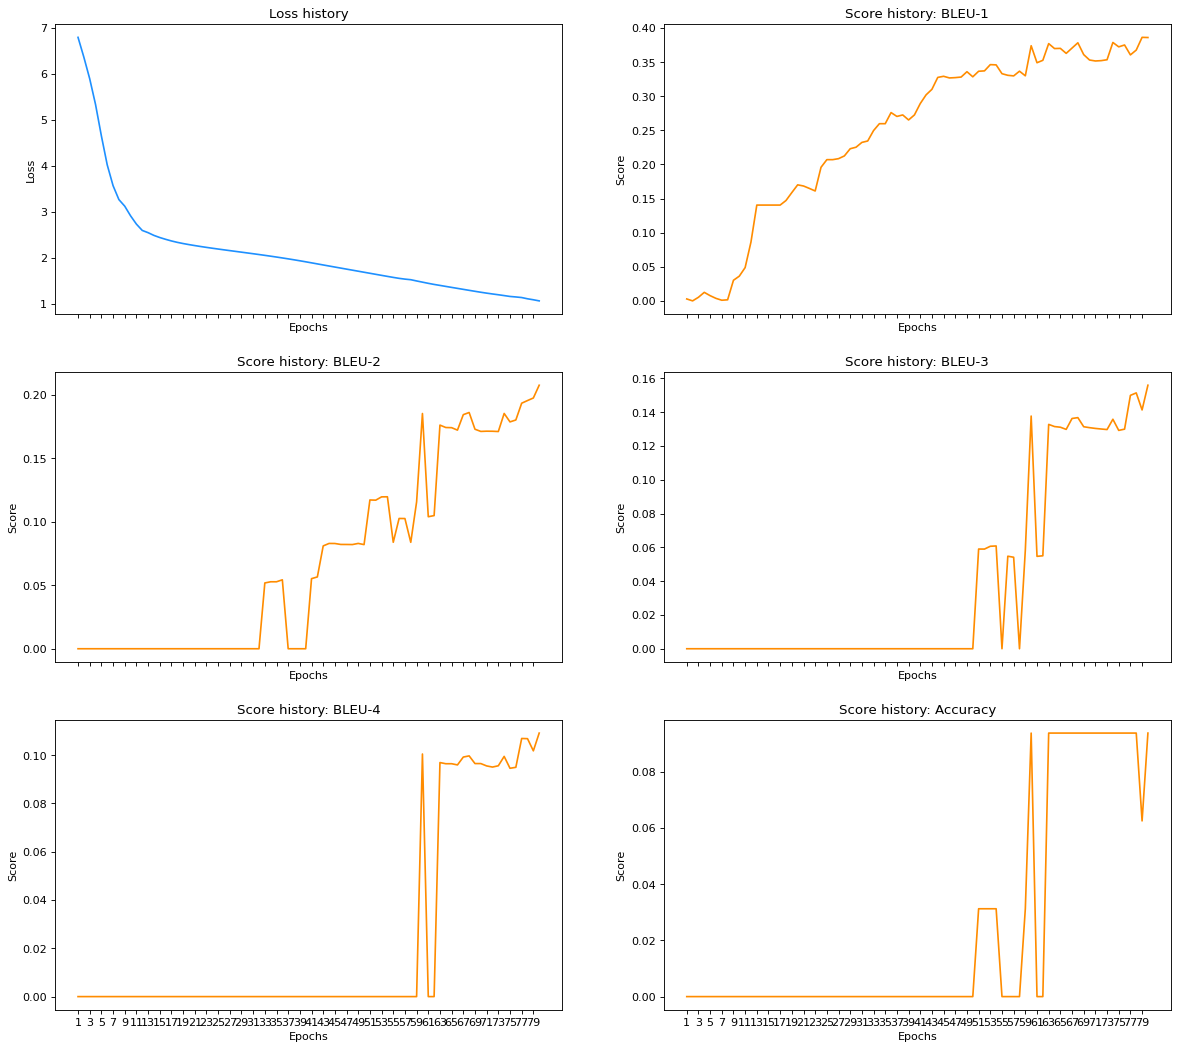

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

nrows = 3
ncols = 2

fig, ax = plt.subplots(nrows, ncols, sharex=True, figsize=(18, 16), dpi= 80,)

epochs = list(range(1, epoch+2))
epochs_ticks = list(range(1, epoch+2, 2))

i = 0
j = 0

ax[i][j].plot(epochs, loss_history, color='dodgerblue')
ax[i][j].set_title('Loss history')
ax[i][j].set_xlabel('Epochs')
ax[i][j].set_xticks(epochs_ticks)
ax[i][j].set_ylabel('Loss')

for name in score_functions.keys():
    j += 1
    if j >= ncols:
        j = 0
        i += 1
    score_history = [s[name] for s in scores_history]
    ax[i][j].plot(epochs, score_history, color='darkorange')
    ax[i][j].set_title('Score history: {}'.format(name))
    ax[i][j].set_xlabel('Epochs')
    ax[i][j].set_xticks(epochs_ticks)
    ax[i][j].set_ylabel('Score')

plt.show()

In [ ]:
examples = zip(dev_source[:10], dev_target[:10], x_development[:10])
for source, target, x in examples:
    y = model(x.unsqueeze(0))
    translation = ' '.join(target_vocab.unidex_words(y[1:-1]))
    source = ' '.join(source)
    references = '\n'.join([' '.join(t) for t in target])

    print('Source: "{}"\nReferences:\n{}\nTranslation: "{}"\n'.format(source, references, translation))

Source: "the vacation is over now ."
References:
vége van a vakációnak .
Translation: "az az az szép ."

Source: "is it bad ?"
References:
ez rossz ?
Translation: "ez van ?"

Source: "where is it ?"
References:
hol van ?
Translation: "hol van ?"

Source: "you may do so ."
References:
megteheted .
Translation: "ez nem ?"

Source: "my little brother is watching tv ."
References:
az kisöcsém tévét néz .
Translation: "az , a az , hogy én én ."

Source: "i need to get to bed ."
References:
le kell feküdnöm .
Translation: "ez egy a tanulni ."

Source: "i just don ' t know what to say ."
References:
csak nem tudom , mit mondjak .
nem tudom , mit mondjak .
Translation: "nem tudom , hogy hogy !"

Source: "i like it very much ."
References:
ez nagyon tetszik nekem .
nekem nagyon tetszik .
Translation: "nem vagyok ."

Source: "it ' s raining ."
References:
esik .
esik az eső .
Translation: "ez ."

Source: "why don ' t you eat vegetables ?"
References:
miért nem eszel zöldséget ?
miért nem eszik ö

<ipython-input-14-dd277e679f60>:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = self.softmax(h)


In [ ]:
test_scores = score(best_model, x_test, test_target)
scores_str = '\n'.join(['{}: {:.4f}'.format(name, score) for name, score in test_scores.items()])
print('Final score:\n' + scores_str)

<ipython-input-18-272aeff678e9>:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, x in tqdm(enumerate(X),


Scoring...:   0%|          | 0/75 [00:00<?, ?it/s]

<ipython-input-14-dd277e679f60>:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = self.softmax(h)


Final score:
BLEU-1: 0.3304
BLEU-2: 0.1313
BLEU-3: 0.0791
BLEU-4: 0.0555
Accuracy: 0.0267
